In [1]:
import base64
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig
from rl_qoc.qua.iqcc import *
from iqcc_calibration_tools.quam_config.components import Quam, Transmon
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    QMInstructionProperties,
    InputType,
    ParameterPool,
)
from qiskit_qm_provider.backend.backend_utils import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    TotalUpdates,
    TrainingConfig,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    StateTarget,
    GateTarget,
    PPOConfig,
    ParametricGateContextWrapper
)
from rl_qoc.helpers import add_custom_gate
from rl_qoc.helpers import load_from_yaml_file

import json
import os
import sys
from pathlib import Path
from gymnasium.wrappers import RescaleObservation, FlattenObservation

from rl_qoc.qua.pi_pulse_reward.pi_pulse_reward import PiPulseReward
from rl_qoc.qua.qua_ppo import CustomQMPPO

# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

backend_name = "gilboa"
machine, iqcc = get_machine_from_iqcc(backend_name, iqcc_config[backend_name])

add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


2025-08-23 14:22:49,053 - qm - INFO     - Starting session: 594479fb-daf3-4650-8328-e7f5eaf76bc1
2025-08-23 14:22:49 INFO Starting session: 594479fb-daf3-4650-8328-e7f5eaf76bc1
Target: Qiskit Backend for Quantum Abstract Machine (Quam)
Number of qubits: 2
Instructions:
	x
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	delay
		(0,):
		(1,):
	reset
		(0,):
			Duration: 5.5292e-05 sec.
		(1,):
			Duration: 0.000131964 sec.
	measure
		(0,):
			Duration: 1.65e-06 sec.
		(1,):
			Duration: 1.65e-06 sec.
	sy
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	sydg
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	id
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case
	box



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/backend_utils.py:215: UserWarning: Could not add default two qubit gates. Add it manually if necessary.
  warnings.warn("Could not add default two qubit gates. Add it manually if necessary.")
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:52: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [20]:
path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/rx_cal"
agent_config_path = os.path.join(path, "agent_config.yaml")
ppo_config = load_from_yaml_file(agent_config_path)


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    qc = add_custom_gate(qc, custom_x, q_reg, params, physical_qubits, backend, instruction_prop)
    return qc


physical_qubits = (0,)

target_name = "rx"
target = GateTarget(gate=target_name, physical_qubits=physical_qubits)
reward =  ChannelReward()

# target_name = "1"
# target = StateTarget(state=target_name, physical_qubits=physical_qubits)
# reward =  StateReward()


# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds

# Environment execution parameters
seed = 1203  # Master seed to make training reproducible
batch_size = 32  # Number of actions to evaluate per policy evaluation
n_shots = 50  # Minimum number of shots per fiducial evaluation
pauli_sampling = 100  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(50)
input_type = InputType.INPUT_STREAM


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
q_env = ParametricGateContextWrapper(q_env, {})
q_env = FlattenObservation(q_env)
q_env = RescaleObservation(q_env, -1.0, 1.0)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)
u_env = rescaled_env.unwrapped


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [21]:
u_env.target.all_context_parameters

[{Parameter(ϴ): None}]

In [22]:
u_env.target.context_parameters

{Parameter(ϴ): None}

In [23]:
rescaled_env.env.env.env.env._get_obs()

{'ϴ': None}

In [24]:
rescaled_env.reset()

(array([0.20325232], dtype=float32),
 {'reset_stage': True, 'step': 1, 'gate_index': 0, 'truncation_index': 0})

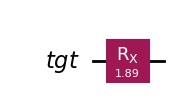

In [25]:
u_env.target.circuit.draw("mpl")

In [26]:
sync_hook_path = generate_sync_hook(
    target=target,
    reward=reward,
    param_bounds=param_bounds,
    seed=seed,
    batch_size=batch_size,
    n_shots=n_shots,
    pauli_sampling=pauli_sampling,
    n_reps=n_reps,
    num_updates=num_updates,
    input_type=input_type,
    backend_config=backend_config,
    ppo_config=ppo_config,
    output_dir=path
    
)
print(f"Sync hook file generated at: {sync_hook_path}")


Sync hook file generated at: /Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/rx_cal/sync_hook.py


In [15]:
if hasattr(q_env.real_time_circuit, "calibrations") and q_env.real_time_circuit.calibrations:
    backend.update_calibrations(qc=q_env.real_time_circuit, input_type=input_type)
backend.update_compiler_from_target()
prog = q_env.rl_qoc_training_qua_prog(num_updates=num_updates.total_updates)

In [16]:
run_data = iqcc.execute(
    prog,
    backend.qm_config,
    terminal_output=True,
    options={"sync_hook": sync_hook_path, "timeout": 600, "profiling": False},
)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


Output()

[22:59:41] QUA program submitted to gilboa (id = eb09484b-ef9b-400e-9a56-7248608ab7de)             ]8;id=93997;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=515339;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#426\426]8;;\

[22:59:42] Execution started                                                                       ]8;id=91503;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=373560;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#446\446]8;;\

[22:59:43] Execution finished                                                                      ]8;id=759948;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=864611;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#460\460]8;;\

QUA program has error:

Traceback (most recent call last):
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 47, in _handle_connection_error
    yield
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 105, in _run
    return run_async(coroutine)
           ^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/utils/async_utils.py", line 38, in run_async
    return create_future(coroutine).result()  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/app/.venv/lib/python3.11/site-packages/qm/grpc/v2/__init__.py", line 1671, in health_check
    return await self._unary_unary(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/betterproto/grpc/grpclib_client.py", line 85, in _unary_unary
    response = await stream.recv_message()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 425, in recv_message
    await self.recv_initial_metadata()
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 393, in recv_initial_metadata
    self._raise_for_grpc_status(status, message, details)
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 345, in _raise_for_grpc_status
    raise GRPCError(status, message, details)
grpclib.exceptions.GRPCError: (<Status.ABORTED: 10>, 'Gateway health is not good enough to answer. Sorry :(', None)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/app/temp.py", line 8321, in <module>
    qmm = QuantumMachinesManager(host="10.1.1.11", port=9510, log_level=logging.ERROR)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/quantum_machines_manager.py", line 186, in __init__
    self.perform_healthcheck(raise_on_error)
  File "/app/.venv/lib/python3.11/site-packages/qm/quantum_machines_manager.py", line 250, in perform_healthcheck
    self._api.perform_healthcheck()
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qmm_api.py", line 209, in perform_healthcheck
    response = self._run(self._stub.health_check(HealthCheckRequest(), timeout=self._timeout))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/base_api_v2.py", line 19, in _run
    response = super()._run(coroutine, timeout)  # type: ignore
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 104, in _run
    with _handle_connection_error(timeout):
  File "/usr/local/lib/python3.11/contextlib.py", line 158, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 55, in _handle_connection_error
    raise QMConnectionError(
qm.exceptions.QMConnectionError: Encountered connection error from QOP: details: Gateway health is not good enough 
to answer. Sorry :(, status: Status.ABORTED

 👍     stdout:

 🚨     stderr:

Traceback (most recent call last):
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 47, in _handle_connection_error
    yield
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 105, in _run
    return run_async(coroutine)
           ^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/utils/async_utils.py", line 38, in run_async
    return create_future(coroutine).result()  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/app/.venv/lib/python3.11/site-packages/qm/grpc/v2/__init__.py", line 1671, in health_check
    return await self._unary_unary(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/betterproto/grpc/grpclib_client.py", line 85, in _unary_unary
    response = await stream.recv_message()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 425, in recv_message
    await self.recv_initial_metadata()
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 393, in recv_initial_metadata
    self._raise_for_grpc_status(status, message, details)
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 345, in _raise_for_grpc_status
    raise GRPCError(status, message, details)
grpclib.exceptions.GRPCError: (<Status.ABORTED: 10>, 'Gateway health is not good enough to answer. Sorry :(', None)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/app/temp.py", line 8321, in <module>
    qmm = QuantumMachinesManager(host="10.1.1.11", port=9510, log_level=logging.ERROR)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/quantum_machines_manager.py", line 186, in __init__
    self.perform_healthcheck(raise_on_error)
  File "/app/.venv/lib/python3.11/site-packages/qm/quantum_machines_manager.py", line 250, in perform_healthcheck
    self._api.perform_healthcheck()
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qmm_api.py", line 209, in perform_healthcheck
    response = self._run(self._stub.health_check(HealthCheckRequest(), timeout=self._timeout))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/base_api_v2.py", line 19, in _run
    response = super()._run(coroutine, timeout)  # type: ignore
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 104, in _run
    with _handle_connection_error(timeout):
  File "/usr/local/lib/python3.11/contextlib.py", line 158, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 55, in _handle_connection_error
    raise QMConnectionError(
qm.exceptions.QMConnectionError: Encountered connection error from QOP: details: Gateway health is not good enough 
to answer. Sorry :(, status: Status.ABORTED

 ⚛️      result

{}

 🕗 🐍  total Python execution time (s)

1.087

 🕗 ⚛️   QUA execution time (s)

0.000